In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset
import seaborn as sns
from matplotlib import pyplot as plt

from open_pref_eval.evaluation import evaluate, evaluate_model

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [5, 5]

In [3]:
N = 600
model_name = "gepardzik/LLama-3-8b-rogue-lora"

In [4]:
imdb = load_dataset('wassname/imdb_dpo', split=f'test[:{N}]', keep_in_memory=False)
imdb

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 600
})

In [5]:
df_agg, df_raw = evaluate_model(
    model_name=model_name, datasets=[imdb],
    per_device_eval_batch_size=3,
    calibrate=90,
    bf16=True,
    )
df_agg

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Parameter 'function'=<bound method DPOTrainer.tokenize_row of <open_pref_eval.trainer.OPETrainer object at 0x702790497450>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Eval imdb_dpo default train:   0%|          | 0/100 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/open_pref_eval/evaluation.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df_train, df_test])


,prob_calib,correct,prob,n
dataset,,,,
imdb_dpo default train,0.688756,0.778333,0.703272,600


In [6]:
((df_raw.prob>0.5)*1).mean(), ((df_raw.prob_calib>0.5)*1).mean()

(0.7333333333333333, 0.59)

In [7]:
# from sklearn.metrics import coverage_error
# import numpy as np
# y_prob = df_raw['prob_calib'].dropna().values[:, None]
# y_true = np.ones(len(y_prob))[:, None]
# y_true = np.array([[1, 0, 0], [0, 1, 1]])[:, :1]
# y_prob = np.array([[1, 0, 0], [0, 1, 1]])[:, :1]
# cov_err = coverage_error(y_true, y_prob)
# print(f'coverage_error: {cov_err}')
# assert cov_err>0

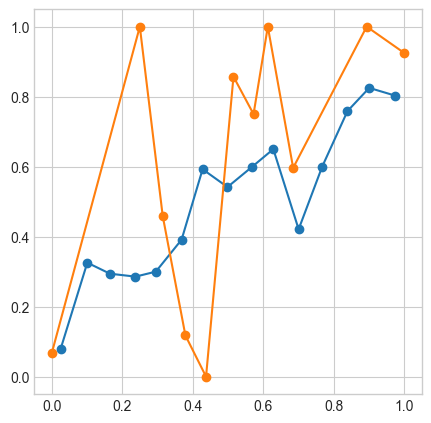

In [9]:
# calibration_curve
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt
y_prob = df_raw['prob'].dropna().values
y_true = np.ones_like(y_prob)

# flip half
y_true[:len(y_true)//2] = 0
y_prob[:len(y_true)//2] = 1 - y_prob[:len(y_true)//2]

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=15, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label=model_name)

y_prob = df_raw['prob_calib'].dropna().values
y_true = np.ones_like(y_prob)

# flip half
y_true[:len(y_true)//2] = 0
y_prob[:len(y_true)//2] = 1 - y_prob[:len(y_true)//2]

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=15, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label=model_name)

In [30]:
from open_pref_eval.evaluation import calibrate_prob
df_raw2 = calibrate_prob(df_raw, N=20)
# df_raw2

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/open_pref_eval/evaluation.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df_train, df_test])


In [48]:
# Simple scaling function
def scale_probs(probs, new_min=0., new_max=1.0):
    return (probs - probs.min()) / (probs.max() - probs.min()) * (new_max - new_min) + new_min

df_raw2['prob_calib'] = scale_probs(df_raw2['prob'])
df_raw2['prob_calib'].describe()

count    600.000000
mean       0.704106
std        0.318971
min        0.000000
25%        0.480941
50%        0.864921
75%        0.973160
max        1.000000
Name: prob_calib, dtype: float64

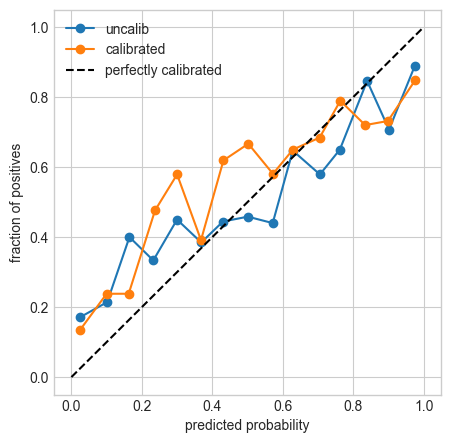

In [49]:
# calibration_curve
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt
y_prob = df_raw2['prob'].dropna().values
y_true = np.ones_like(y_prob)

# flip half
flip = np.random.choice([0, 1], size=len(y_true))==1
y_true[flip] = 1 - y_true[flip]
y_prob[flip] = 1 - y_prob[flip]

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=15, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label='uncalib')

y_prob = df_raw2['prob_calib'].dropna().values
y_true = np.ones_like(y_prob)

# flip half
flip = np.random.choice([0, 1], size=len(y_true))==1
y_true[flip] = 1 - y_true[flip]
y_prob[flip] = 1 - y_prob[flip]

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=15, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label='calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='perfectly calibrated')
plt.xlabel('predicted probability')
plt.ylabel('fraction of positives')

plt.legend()

In [50]:
df_agg =  df_raw.groupby(['dataset'], dropna=False)[['correct', 'prob', 'prob_calib']].mean()
df_agg

,correct,prob,prob_calib
dataset,,,
imdb_dpo default train,0.778333,0.703272,0.688756


In [51]:
((df_raw.prob_calib>0.5)*1).mean()

0.59

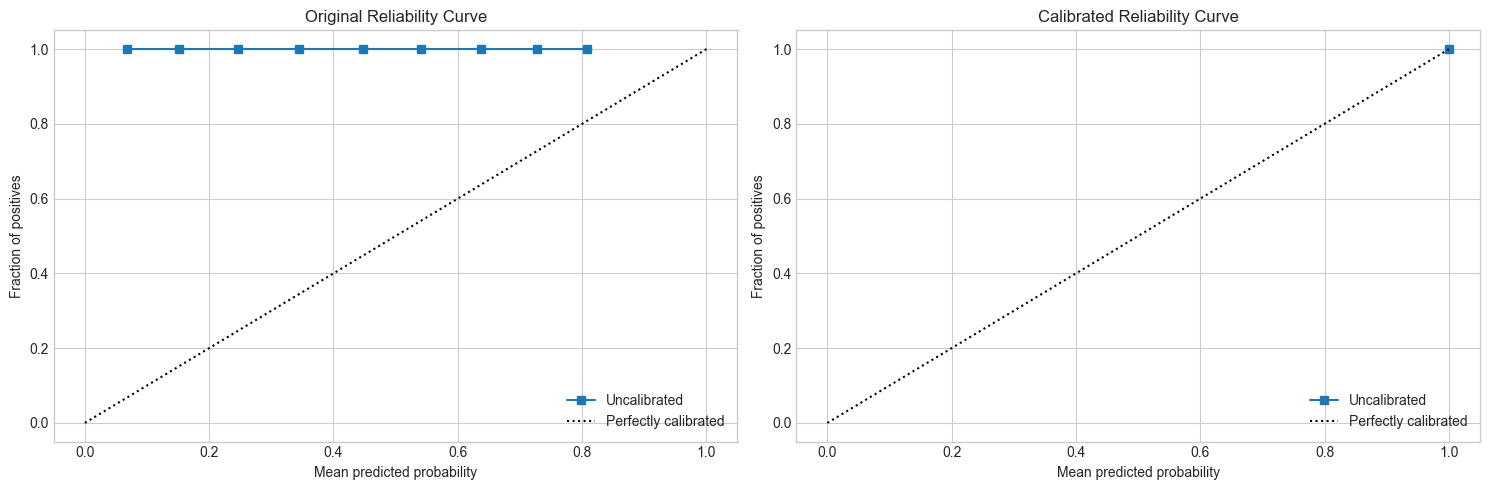

Sample original probabilities:
[0.35367666 0.24855807 0.41595909 0.15996758 0.55028308 0.11094529
 0.50989664 0.17727038 0.19829047 0.37623679]

Sample calibrated probabilities:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Mean original probability: 0.286
Mean calibrated probability: 1.000


In [38]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.calibration import calibration_curve
# from sklearn.isotonic import IsotonicRegression

# # Generate sample data
# np.random.seed(42)
# n_samples = 1000

# # Generate probabilities between 0 and 1
# # Using beta distribution to simulate a more realistic probability distribution
# probabilities = np.random.beta(2, 5, n_samples)

# # All labels are 1
# labels = np.ones(n_samples)

# # Function to plot reliability curve
# def plot_reliability_curve(y_true, y_prob, n_bins=10, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots()
    
#     fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=n_bins)
    
#     ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="Uncalibrated")
#     ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
#     ax.set_xlabel("Mean predicted probability")
#     ax.set_ylabel("Fraction of positives")
#     ax.set_title("Reliability Curve")
#     ax.legend(loc="lower right")
#     return ax

# # Plot original reliability curve
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plot_reliability_curve(labels, probabilities, ax=ax1)
# ax1.set_title("Original Reliability Curve")

# # Apply isotonic regression for calibration
# ir = IsotonicRegression(out_of_bounds="clip")
# calibrated_probs = ir.fit_transform(probabilities, labels)

# # Plot calibrated reliability curve
# plot_reliability_curve(labels, calibrated_probs, ax=ax2)
# ax2.set_title("Calibrated Reliability Curve")

# plt.tight_layout()
# plt.show()

# # Print some sample probabilities
# print("Sample original probabilities:")
# print(probabilities[:10])
# print("\nSample calibrated probabilities:")
# print(calibrated_probs[:10])

# # Calculate mean probabilities
# print(f"\nMean original probability: {np.mean(probabilities):.3f}")
# print(f"Mean calibrated probability: {np.mean(calibrated_probs):.3f}")